In [10]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns #Sorts the data like lables, arranges it into acc or dess order and plots a histogram like visual
import matplotlib.pyplot as plt 
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Data Processing


In [11]:
train_dir = 'Training'

classes = os.listdir(train_dir)
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [12]:
image_paths = []
image_labels = []

categories = os.listdir(train_dir)

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

train_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
train_df

,filepaths,labels
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


In [14]:
test_dir ='Testing'

classes = os.listdir(test_dir)
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [15]:
image_paths = []
image_labels = []

categories = os.listdir(test_dir)

for category in categories:
    category_path = os.path.join(test_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

test_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
test_df

,filepaths,labels
0,Testing\glioma\Te-glTr_0000.jpg,glioma
1,Testing\glioma\Te-glTr_0001.jpg,glioma
2,Testing\glioma\Te-glTr_0002.jpg,glioma
3,Testing\glioma\Te-glTr_0003.jpg,glioma
4,Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Testing\pituitary\Te-pi_0298.jpg,pituitary


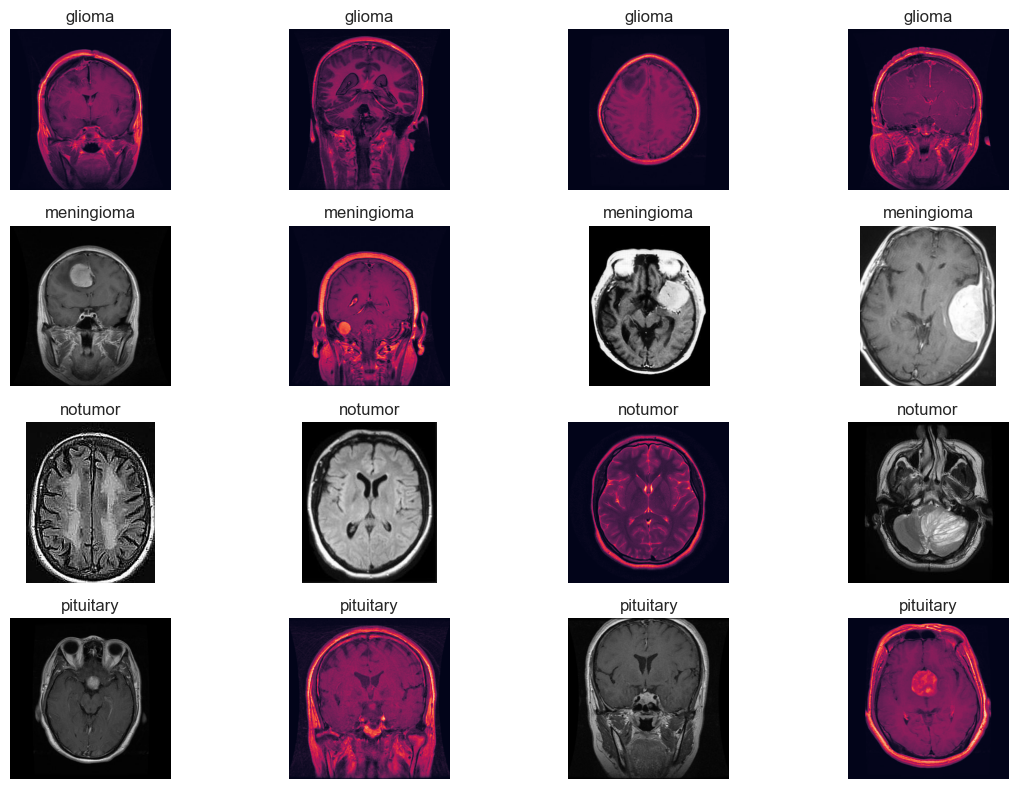

In [16]:
def plot_class_samples(df, classes, num_samples=4):
    plt.figure(figsize=(12,8))
    
    for i, cls in enumerate(classes):
        class_images = df[df['labels'] == cls]['filepaths'].sample(num_samples, random_state=42)
        
        for j, img_path in enumerate(class_images):
            img = Image.open(img_path)  # Load the image
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
    
    plt.tight_layout()
    plt.show()
classes = train_df['labels'].unique()

plot_class_samples(train_df, classes)

Text(0.5, 1.0, 'Train labels count')

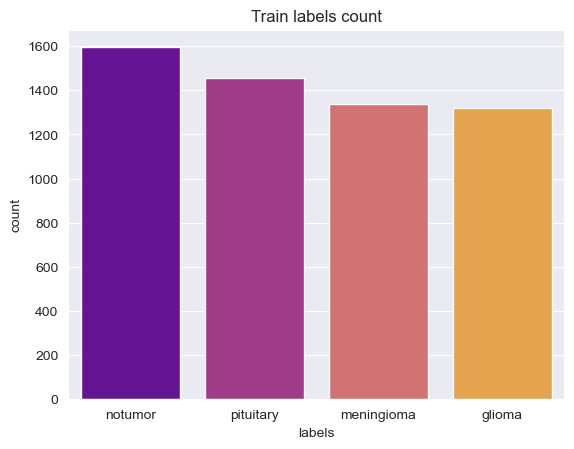

In [17]:
sns.countplot(data=train_df,x='labels',palette='plasma',order=train_df['labels'].value_counts().index )
plt.title('Train labels count')

Text(0.5, 1.0, 'Test labels count')

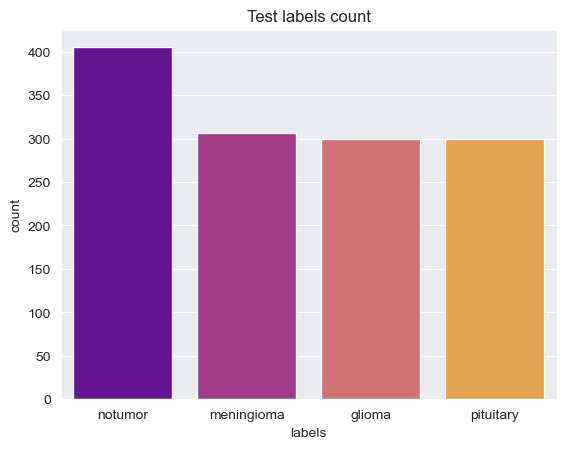

In [18]:
sns.countplot(data=test_df,x='labels',palette='plasma',order=test_df['labels'].value_counts().index )
plt.title('Test labels count')

# CNN Model and Splitting

In [20]:
train_df.shape[0]

4569

In [19]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [21]:
valid_df.shape[0]

1143

In [22]:
train_df.shape[0]

4569

In [23]:
image_gen = ImageDataGenerator(rescale=1/255)

In [24]:
gen_train=image_gen.flow_from_dataframe(train_df,x_col='filepaths',y_col='labels',target_size=(224,224),class_mode='categorical',color_mode='rgb',batch_size=32)
gen_valid=image_gen.flow_from_dataframe(valid_df,x_col='filepaths',y_col='labels',target_size=(224,224),class_mode='categorical',color_mode='rgb',batch_size=32)
gen_test=image_gen.flow_from_dataframe(test_df,x_col='filepaths',y_col='labels',target_size=(224,224),class_mode='categorical',color_mode='rgb',batch_size=32,shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [25]:
model=Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))

model.compile(optimizer=Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
early_stopping=EarlyStopping(monitor='val_loss',mode='min',patience=7)

In [18]:
history= model.fit(gen_train,validation_data=gen_valid,epochs=30,callbacks=[early_stopping])

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 519ms/step - accuracy: 0.4283 - loss: 1.2018 - val_accuracy: 0.7717 - val_loss: 0.5941
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 303ms/step - accuracy: 0.7365 - loss: 0.6545 - val_accuracy: 0.8390 - val_loss: 0.5016
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 301ms/step - accuracy: 0.8200 - loss: 0.4917 - val_accuracy: 0.8871 - val_loss: 0.3456
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 301ms/step - accuracy: 0.8749 - loss: 0.3376 - val_accuracy: 0.8889 - val_loss: 0.3291
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - accuracy: 0.9054 - loss: 0.2954 - val_accuracy: 0.9099 - val_loss: 0.2740
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - accuracy: 0.8972 - loss: 0.2686 - val_accuracy: 0.9073 - val_loss: 0.2533
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 303ms/step - accuracy: 0.9297 - loss: 0.2109 - val_accuracy: 0.9178 - val_loss: 0.2174
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - accuracy: 0.9311 - loss: 0

In [19]:
losses=pd.DataFrame(history.history)

Text(0.5, 1.0, 'Model Accuracy')

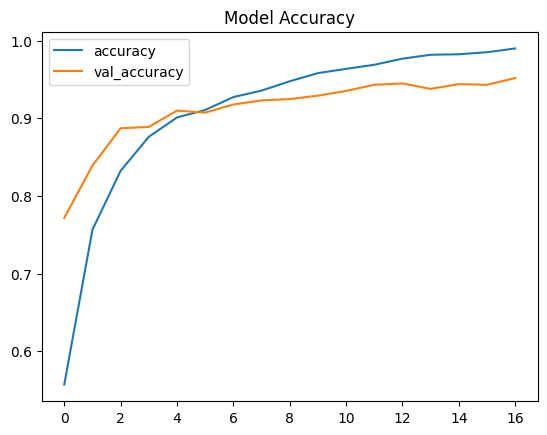

In [20]:
losses[['accuracy','val_accuracy']].plot()
plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Loss')

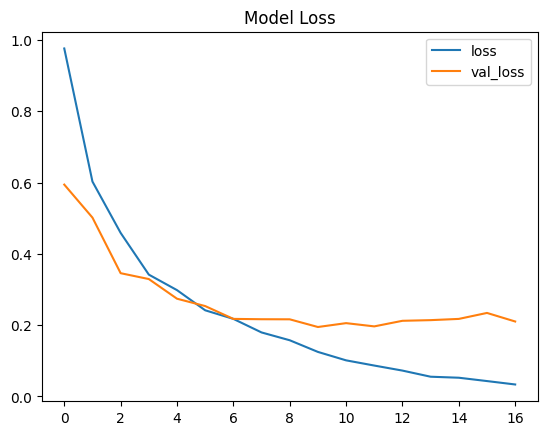

In [21]:
losses[['loss','val_loss']].plot()
plt.title('Model Loss')

In [22]:
pred=model.predict(gen_test)
predictions=np.argmax(pred,axis=1)
print(classification_report(gen_test.classes,predictions))

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       300
           1       0.93      0.92      0.93       306
           2       0.98      1.00      0.99       405
           3       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [25]:
model.evaluate(gen_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9790 - loss: 0.0786


[0.14667436480522156, 0.9641494750976562]

In [23]:
model.save('Model1.h5')

<Axes: >

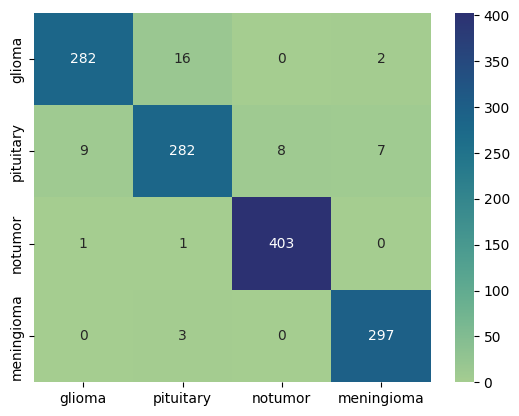

In [24]:
conf_matrix = confusion_matrix(gen_test.classes, predictions)
labels = list(train_df['labels'].unique())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels)

# Prediction on Random Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


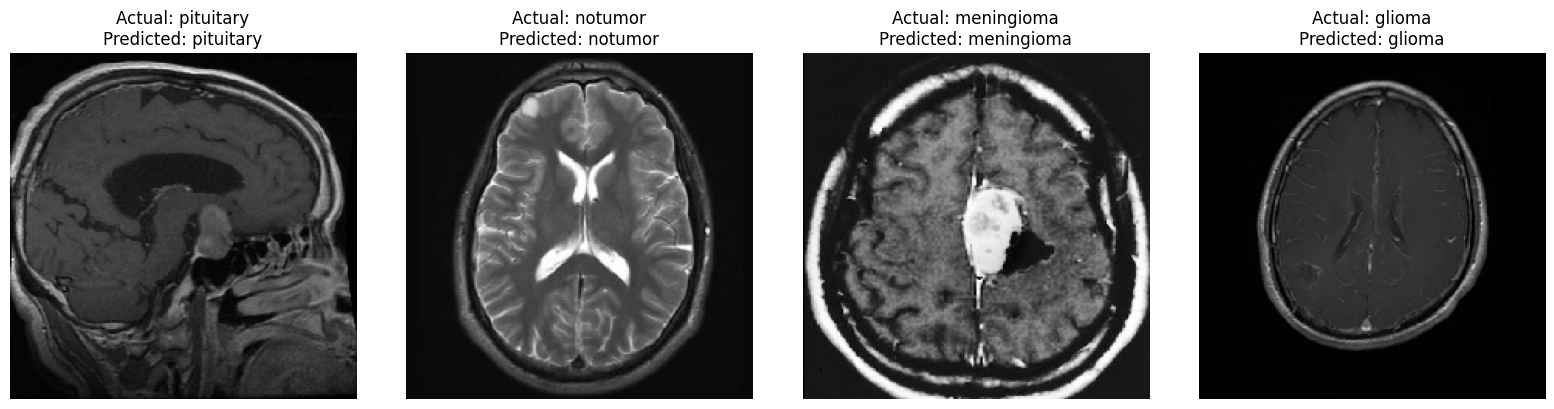

In [54]:
import random
random_indices = random.sample(range(len(test_df)), 4)
random_paths = test_df.iloc[random_indices]['filepaths'].values
actual_labels = test_df.iloc[random_indices]['labels'].values

plt.figure(figsize=(16, 4))

for i, img_path in enumerate(random_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)[0]
    class_labels = list(gen_train.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Actual: {actual_labels[i]}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()